In [1]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            img = cv2.imread(os.path.join(folder, filename))
            if img is not None:
                images.append(img)
    return images

In [2]:
def preprocess_and_flatten(images, label):
    # Convert to grayscale and resize
    resized_gray_images = [cv2.resize(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), (200, 200)) for img in images]
    
    # Flatten and append class label
    flattened_images_with_labels = [np.append(img.flatten(), label) for img in resized_gray_images]
    
    return flattened_images_with_labels

In [3]:
folder_path_class1 = r'C:\Users\786me\Desktop\FinalYearProject\ASDScanPath\ASD\Augmented5x\Control'
folder_path_class2 = r'C:\Users\786me\Desktop\FinalYearProject\ASDScanPath\ASD\Augmented5x\Patient'

# Load images from each class folder
images_class1 = load_images_from_folder(folder_path_class1)
images_class2 = load_images_from_folder(folder_path_class2)

# Preprocess and flatten images, then append class labels
flattened_images_class1 = preprocess_and_flatten(images_class1, 0)
flattened_images_class2 = preprocess_and_flatten(images_class2, 1)

In [4]:
# Stack the processed images into a single array
all_images = np.vstack((flattened_images_class1, flattened_images_class2))

print(all_images.shape)

(2550, 40001)


In [6]:
# Split the data into train and test sets (70:30)
X = all_images[:, :-1]
y = all_images[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [7]:
# Reshape the flattened images back into 2D images
X_train = X_train.reshape(-1, 200, 200, 1)
X_test = X_test.reshape(-1, 200, 200, 1)

In [8]:
# Create the CNN model
model = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(200, 200, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [9]:
# Train the model
model.fit(X_train, y_train, batch_size=32, epochs=10, validation_split=0.2)

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test loss: {loss}")
print(f"Test accuracy: {accuracy}")

Epoch 1/10
45/45 [==============================] - 17s 335ms/step - loss: 0.7841 - accuracy: 0.7066 - val_loss: 0.5035 - val_accuracy: 0.7535
Epoch 2/10
45/45 [==============================] - 14s 309ms/step - loss: 0.4016 - accuracy: 0.8186 - val_loss: 0.4455 - val_accuracy: 0.7787
Epoch 3/10
45/45 [==============================] - 14s 305ms/step - loss: 0.2759 - accuracy: 0.8880 - val_loss: 0.3596 - val_accuracy: 0.8375
Epoch 4/10
45/45 [==============================] - 14s 305ms/step - loss: 0.1460 - accuracy: 0.9447 - val_loss: 0.5068 - val_accuracy: 0.8151
Epoch 5/10
45/45 [==============================] - 14s 304ms/step - loss: 0.0699 - accuracy: 0.9776 - val_loss: 0.5232 - val_accuracy: 0.8431
Epoch 6/10
45/45 [==============================] - 14s 305ms/step - loss: 0.0742 - accuracy: 0.9706 - val_loss: 0.5346 - val_accuracy: 0.8347
Epoch 7/10
45/45 [==============================] - 14s 311ms/step - loss: 0.0444 - accuracy: 0.9839 - val_loss: 0.6071 - val_accuracy: 0.8459

24/24 [==============================] - 2s 63ms/step


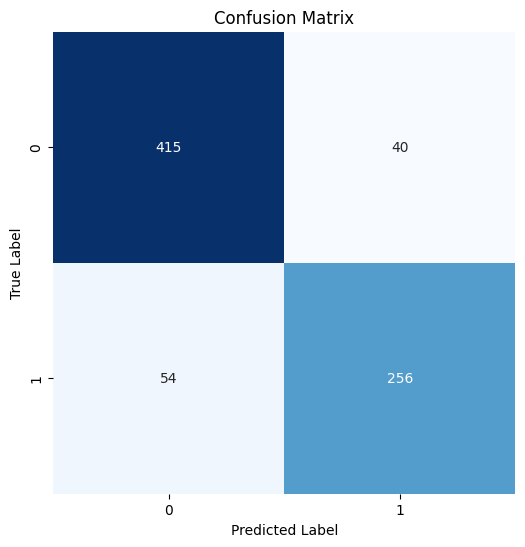

In [10]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
# Make predictions on the test data
y_pred_proba = model.predict(X_test)
y_pred = (y_pred_proba > 0.5).astype(int).flatten()

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Visualize the confusion matrix as a heatmap
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, square=True)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

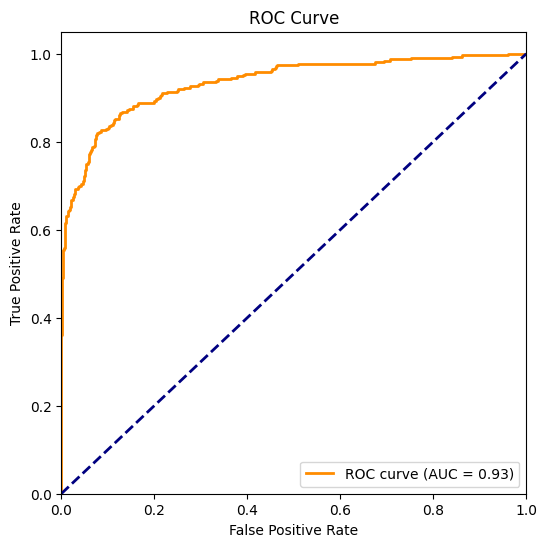

In [11]:
from sklearn.metrics import roc_curve, auc

# Calculate the false positive rate (FPR), true positive rate (TPR), and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()